<a href="https://colab.research.google.com/github/silvidae1/Computer-Vision-Wind-Turbine/blob/main/ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final - Visão por Computador

**Estudantes:**


> João Paulo Gregório Pereira da Silva - up201904991

> Paulo Ricardo Santos e Silva - up201906290

Drone images offer a unique aerial perspective of wind turbines, allowing for a comprehensive
view of the entire structure, including the blades, nacelle, and tower. This perspective is crucial
for inspecting and evaluating the overall condition of the turbine. Routine drone inspections are
an integral part of wind turbine maintenance. These images help maintenance teams identify
issues like blade erosion, lightning strikes, or structural damage that may require immediate
attention.


In [1]:
#--------------------- ONLY FOR COLAB --------------------------------------------
#!git clone https://github.com/silvidae1/Computer-Vision-Wind-Turbine.git


Cloning into 'Computer-Vision-Wind-Turbine'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 609 (delta 1), reused 8 (delta 1), pack-reused 601
Receiving objects: 100% (609/609), 1.96 GiB | 36.18 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (727/727), done.


**IMPORTS**



In [1]:
import torch.utils.data as data
import pandas as pd
import json
#!git clone https://github.com/ultralytics/yolov5  # ONLY needed in colab, in vSCODE run on the terminal
%cd yolov5
%pip install -qr requirements.txt
%pip install pylabel
from pylabel import importer
import cv2
import os
import matplotlib.pyplot as plt
import shutil



c:\Users\jpgps\OneDrive - Universidade do Porto\5º Ano\Visão por Computador\Projeto Final\Computer-Vision-Wind-Turbine\yolov5
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**DIVIDE IMAGES**

In [2]:
def divide_images(input_folder, output_folder, subimage_size):
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Iterate through each image file
    for image_file in image_files:
        input_image_path = os.path.join(input_folder, image_file)

        # Read the input image
        input_image = cv2.imread(input_image_path)

        # Get the dimensions of the input image
        height, width, _ = input_image.shape

        # Set the size of the sub-images
        subimage_width, subimage_height = subimage_size

        # Iterate through the input image and create sub-images
        for y in range(0, height, subimage_height):
            for x in range(0, width, subimage_width):
                subimage = input_image[y:y+subimage_height, x:x+subimage_width]

                # Save the sub-image
                file_name = image_file[0:-4]
                subimage_filename = f"{file_name}_{int(y/1024)}_{int(x/1024)}.JPG"
                subimage_path = os.path.join(output_folder, subimage_filename)
                cv2.imwrite(subimage_path, subimage)

In [3]:
input_folder_path = "../ImagesAll"
output_folder_path = "../dividedImages"
subimage_size = (1024, 1024)

divide_images(input_folder_path, output_folder_path, subimage_size)

Testing Annotations

In [72]:
path_to_annotations = r"../DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json"

#For Colab
#path_to_annotations = r"/content/Computer-Vision-Wind-Turbine/DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json"

#Specify the path to the images (if they are in a different folder than the annotations)

path_to_images = r"../../../../dividedImages"
#For Colab
#path_to_images = r"/content/Computer-Vision-Wind-Turbine/dividedImages""


#Import the dataset into the pylable schema

dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="Segmentation")

dataset.df.head(10)

dataset.path_to_annotations = r"../DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json"
#For Colab
#path_to_annotations = r"/content/Computer-Vision-Wind-Turbine/DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json"


dataset.export.ExportToYoloV5()[0]

Exporting YOLO files...:   0%|          | 0/423 [00:00<?, ?it/s]

Exporting YOLO files...: 100%|██████████| 423/423 [00:01<00:00, 358.49it/s]


'training\\dataset.yaml'

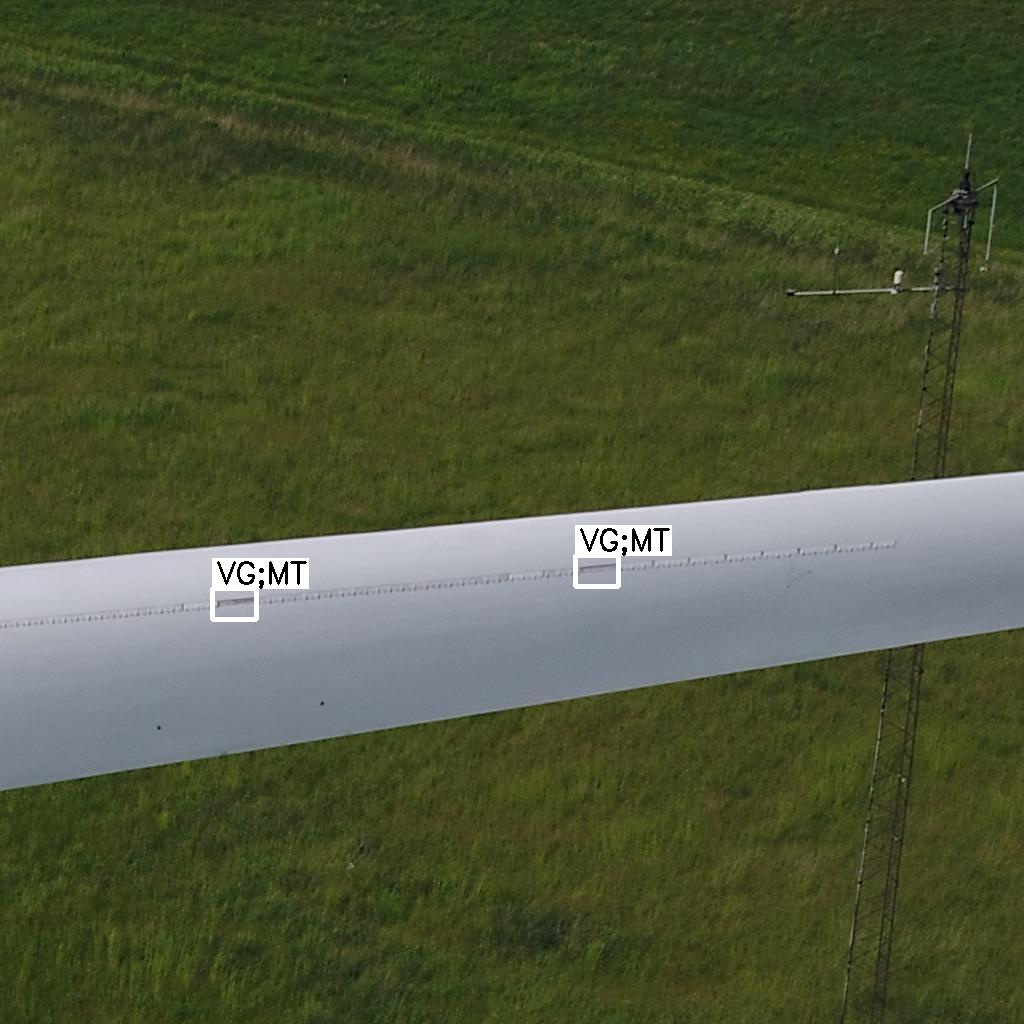

In [76]:
from IPython.display import Image, display

display(dataset.visualize.ShowBoundingBoxes(1))

YOLO BENCHMARKING

In [101]:
def json_to_yolo(json_file, output_folder):
    with open(json_file, 'r') as f:
        data = json.load(f)

    categories_dict = {category['id']: category['name'] for category in data['categories']}

    for image in data['images']:
        image_id = image['id']
        image_file_name = image['file_name']
        image_width = image['width']
        image_height = image['height']

        yolo_annotations = []

        for annotation in data['annotations']:
            if annotation['image_id'] == image_id:
                category_id = annotation['category_id']
                category_name = categories_dict[category_id]

                x, y, w, h = annotation['bbox']
                x_center = x + w / 2
                y_center = y + h / 2

                x_center /= image_width
                y_center /= image_height
                w /= image_width
                h /= image_height

                yolo_annotations.append(f"{category_id} {x_center} {y_center} {w} {h}")

        if yolo_annotations:
            output_file_path = os.path.join(output_folder, os.path.splitext(image_file_name)[0] + '.txt')
            with open(output_file_path, 'w') as yolo_file:
                yolo_file.write('\n'.join(yolo_annotations))



In [102]:
def copyImageSets (JsonFile, dest):
    with open(JsonFile, 'r') as f:
        file = json.load(f)

    # Specify the source folder containing images
    source_folder_img = '../dividedImages'

    # Specify the destination folder where you want to move the matching images
    destination_folder = dest

    # Iterate through annotations and move matching images
    annotations = file['images']
    for annotation in annotations:
        file_name = annotation['file_name']
        source_path = os.path.join(source_folder_img, file_name)
        destination_path = os.path.join(destination_folder, file_name)

        try:
            # Move the file
            shutil.move(source_path, destination_path)
            print(f"Moved {file_name} to {destination_folder}")
        except FileNotFoundError:
            print(f"File not found: {file_name}")

    print("Move operation completed.")

In [105]:
train_json = '../DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json'
#train_annotations = 
train_images = '../MyData/train/images/'
output_folder_train = '../MyData/train/labels'
json_to_yolo(train_json, output_folder_train)
copyImageSets(train_json, train_images)


val_json = '../DTU-annotations-main/DTU-annotations-main/annotations/val1024-s.json'
#train_annotations =
val_images = '../MyData/val/images/'
output_folder_val = '../MyData/val/labels'
json_to_yolo(val_json, output_folder_val)
copyImageSets(val_json, val_images)

Moved DJI_0058_1_3.JPG to ../MyData/train/images/
Moved DJI_0013_0_3.JPG to ../MyData/train/images/
Moved DJI_0013_1_1.JPG to ../MyData/train/images/
Moved DJI_0168_0_3.JPG to ../MyData/train/images/
Moved DJI_0168_0_4.JPG to ../MyData/train/images/
Moved DJI_0168_1_2.JPG to ../MyData/train/images/
Moved DJI_0131_1_1.JPG to ../MyData/train/images/
Moved DJI_0212_0_2.JPG to ../MyData/train/images/
Moved DJI_0212_1_2.JPG to ../MyData/train/images/
Moved DJI_0700_0_1.JPG to ../MyData/train/images/
Moved DJI_0700_1_3.JPG to ../MyData/train/images/
Moved DJI_0177_0_2.JPG to ../MyData/train/images/
Moved DJI_0177_1_2.JPG to ../MyData/train/images/
Moved DJI_0394_0_4.JPG to ../MyData/train/images/
Moved DJI_0449_0_1.JPG to ../MyData/train/images/
Moved DJI_0449_0_2.JPG to ../MyData/train/images/
Moved DJI_0449_1_1.JPG to ../MyData/train/images/
Moved DJI_0449_1_2.JPG to ../MyData/train/images/
Moved DJI_0450_1_2.JPG to ../MyData/train/images/
Moved DJI_0696_1_1.JPG to ../MyData/train/images/


In [106]:
!python train.py --img 640 --batch 16 --epochs 3 --data ../yolov5/training/dataset.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=../yolov5/training/dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
unknown option: -
usage: git [-v | --version] [-h | --help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [-

In [ ]:
f = open('/content/Computer-Vision-Wind-Turbine/DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json')
data = json.load(f)

# for i in data:
#   for n in data[i]:
#     print(n)
print(data['images'])
# Closing file
f.close()
# df = pd.read_json("/content/Computer-Vision-Wind-Turbine/DTU-annotations-main/annotations/train1024-s.json")
# print(df)

[{'id': 0, 'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/', 'file_name': 'DJI_0058_1_3.JPG', 'path': None, 'width': 1024, 'height': 1024, 'depth': 3}, {'id': 1, 'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/', 'file_name': 'DJI_0013_0_3.JPG', 'path': None, 'width': 1024, 'height': 1024, 'depth': 3}, {'id': 2, 'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/', 'file_name': 'DJI_0013_1_1.JPG', 'path': None, 'width': 1024, 'height': 1024, 'depth': 3}, {'id': 3, 'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/', 'file_name': 'DJI_0168_0_3.JPG', '

In [ ]:
images = data['images']
annotations = data['annotations']
categories = {c['id']: c['name'] for c in data['categories']}
folder = "/content/Computer-Vision-Wind-Turbine/Data/Nordtank2018"
output_path  = "/content/Dataset/Images/"

for image in images:
  file_name = image['file_name']
  file_id = str(image['id'])

  print(file_name)
  file_name = file_name[0:-8]
  print(file_name)

  # for filename in os.listdir(folder):
  #       source = os.path.join(folder,filename)
  #       destination = f"{output_path}{'img' + file_id}.jpg"

  #       try:
  #           shutil.copy(source, destination)
  #           print("File copied successfully.")
  #       # If source and destination are same
  #       except shutil.SameFileError:
  #           print("Source and destination represents the same file.")

  #       #file_names.append(filename)


  bounding_boxes = []

  for annotation in annotations:
    if annotation['image_id'] == image['id']:

      category_id = annotation['category_id']

      x, y, w, h = annotation['bbox']

      x = ((x + w)/2) / image['width']
      y = ((y+h)/2) / image['height']
      w = w / image['width']
      h = h / image['height']

      bounding_box_str = f"{category_id} {x + w/2} {y + h/2} {w} {h}"
      bounding_boxes.append(bounding_box_str)

  with open(f"/content/Dataset/Labels/{file_name}.txt", 'w') as f:
      # Write the bounding boxes to the text file
      for bounding_box in bounding_boxes:
        f.write(f"{bounding_box}\n")

path_to_annotations = "/content/Dataset/Labels"
path_to_images = "/content/Computer-Vision-Wind-Turbine/Data/Nordtank2018"

dataset = importer(path_to_annotations, path_to_images=path_to_images, name="Segmentation")

dataset.df.head(10)

dataset.path_to_annotations = r"/content/Computer-Vision-Wind-Turbine/DTU-annotations-main/DTU-annotations-main/annotations/train1024-s.json"


DJI_0058_1_3.JPG
DJI_0058
DJI_0013_0_3.JPG
DJI_0013
DJI_0013_1_1.JPG
DJI_0013
DJI_0168_0_3.JPG
DJI_0168
DJI_0168_0_4.JPG
DJI_0168
DJI_0168_1_2.JPG
DJI_0168
DJI_0131_1_1.JPG
DJI_0131
DJI_0212_0_2.JPG
DJI_0212
DJI_0212_1_2.JPG
DJI_0212
DJI_0700_0_1.JPG
DJI_0700
DJI_0700_1_3.JPG
DJI_0700
DJI_0177_0_2.JPG
DJI_0177
DJI_0177_1_2.JPG
DJI_0177
DJI_0394_0_4.JPG
DJI_0394
DJI_0449_0_1.JPG
DJI_0449
DJI_0449_0_2.JPG
DJI_0449
DJI_0449_1_1.JPG
DJI_0449
DJI_0449_1_2.JPG
DJI_0449
DJI_0450_1_2.JPG
DJI_0450
DJI_0696_1_1.JPG
DJI_0696
DJI_0696_1_2.JPG
DJI_0696
DJI_0696_1_3.JPG
DJI_0696
DJI_0688_0_2.JPG
DJI_0688
DJI_0688_1_2.JPG
DJI_0688
DJI_0688_1_3.JPG
DJI_0688
DJI_0012_0_3.JPG
DJI_0012
DJI_0012_0_4.JPG
DJI_0012
DJI_0012_1_2.JPG
DJI_0012
DJI_0751_0_1.JPG
DJI_0751
DJI_0751_0_2.JPG
DJI_0751
DJI_0751_1_4.JPG
DJI_0751
DJI_0693_0_2.JPG
DJI_0693
DJI_0693_1_3.JPG
DJI_0693
DJI_0249_0_3.JPG
DJI_0249
DJI_0249_0_4.JPG
DJI_0249
DJI_0249_1_3.JPG
DJI_0249
DJI_0019_0_2.JPG
DJI_0019
DJI_0019_0_3.JPG
DJI_0019
DJI_0019_0_4

TypeError: ignored

In [ ]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")